<a href="https://colab.research.google.com/github/SirOnuigweVitus/MyProjects/blob/master/COVID19_Xray_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip COVID-19.zip

Archive:  COVID-19.zip
   creating: COVID19/dataset/
   creating: COVID19/dataset/covid/
  inflating: COVID19/dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID19/dataset/covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: COVID19/dataset/covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: COVID19/dataset/covid/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: COVID19/dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: COVID19/dataset/covid/lancet-case2a.jpg  
  inflating: COVID19/dataset/covid/lancet-case

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import History,EarlyStopping,LearningRateScheduler
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, Adadelta, RMSprop
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [0]:
PATH="/content/COVID19"
dataset_dir = os.path.join(PATH, 'dataset')
train_covid_dir = os.path.join(dataset_dir, 'covid')  # directory with our training COVID-19+ pictures
train_normal_dir = os.path.join(dataset_dir, 'normal')  # directory with our training COVID-19- pictures

In [4]:
num_covid_dir = len(os.listdir(train_normal_dir))
num_normal_dir = len(os.listdir(train_normal_dir))
print('total training covid images:', num_covid_dir)

total training covid images: 25


In [0]:
batch_size = 28
epochs = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224
image_gen_train = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.01,
        height_shift_range=0.01,
        rescale=1./255,
        shear_range=0.1,
        fill_mode='nearest',
        validation_split=0.2)

In [6]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=dataset_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary') # set as training data

val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=dataset_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary') # set as validation data

Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


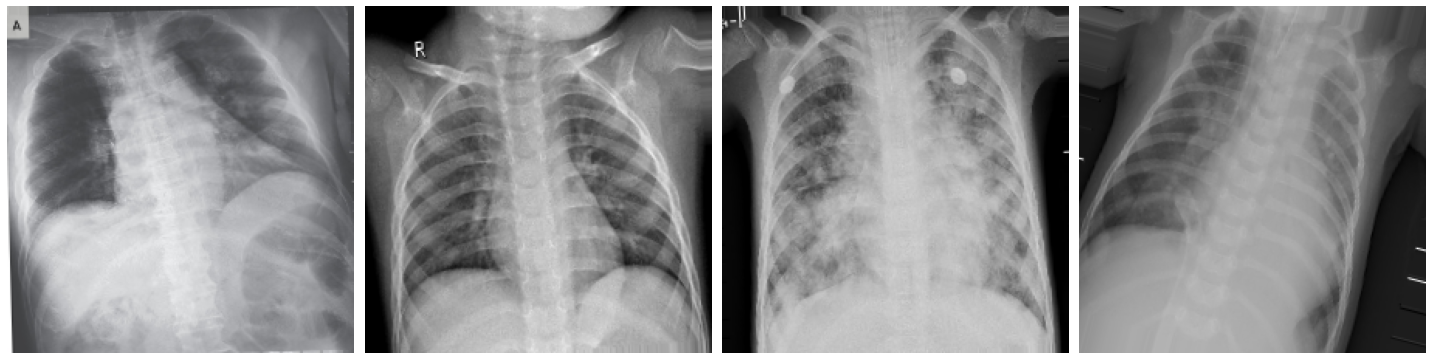

In [7]:
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:4])

In [0]:
#the model
model = Sequential()
model.add(Conv2D(64, kernel_size= (3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),padding='same'))

model.add(BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, kernel_size =(3,3),padding='same'))
model.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128,(3,3), padding='same' ))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(256, kernel_size = (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size= (3,3) ,padding='same'))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
#model.summary()
model.save("model.h5")
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch= train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= val_data_gen.samples // batch_size,verbose=1)

Epoch 1/20
1/1 [==============================] - 16s 16s/step - loss: 0.7367 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.6071
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 0.6709 - accuracy: 0.8636 - val_loss: 0.6941 - val_accuracy: 0.3636
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.0437 - accuracy: 0.9643 - val_loss: 0.6929 - val_accuracy: 0.4286
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.3509 - accuracy: 0.9545 - val_loss: 0.6754 - val_accuracy: 0.5909
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.3825 - accuracy: 0.9091 - val_loss: 0.5976 - val_accuracy: 0.9286
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.0408 - accuracy: 0.9643 - val_loss: 0.3724 - val_accuracy: 0.8636
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.2757 - val_accuracy: 0.9643
Epoch 8/20
1/1 [=======================

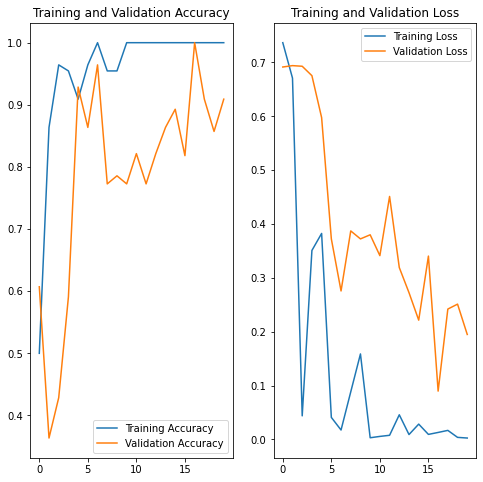

In [12]:
#model evaluate
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
#Confusion Matrix and Classification Report
 validation_data = val_data_gen
 validation_steps = val_data_gen.samples
 batch_size = batch_size
 import numpy as np
 import argparse
 from sklearn.metrics import confusion_matrix
 from sklearn.metrics import classification_report
 Y_pred = model.predict_generator(validation_data, validation_steps // 
 batch_size+1)
 y_pred = np.argmax(Y_pred, axis=1)
 
 print('Confusion Matrix')
 print(confusion_matrix(validation_data.classes, y_pred))
 print('Classification Report')
 target_names = ['covid', 'normal']
 print(classification_report(validation_data.classes, y_pred, 
 target_names=target_names))

Confusion Matrix
[[25  0]
 [25  0]]
Classification Report
              precision    recall  f1-score   support

       covid       0.50      1.00      0.67        25
      normal       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
